# Task2 - Experiments on CelebA Dataset

**Author: Bolun Li (UNI: bl3147)  
Task2: Experiments on CelebA Dataset**

<span style="font-size: 1.2em;">The "faces" dataset used in the paper is not publicly available; therefore, this project will use the "CelebA" dataset as a substitute to reproduce the experiments conducted on the faces dataset in the paper.</span>

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys


project_root = "/home/ecbm4040/e4040-fall2025-project-TEAM-bl3147-zz3459-dn2659"

sys.path.append(project_root)

os.chdir(project_root)
print("Working directory:", os.getcwd())


Working directory: /home/ecbm4040/e4040-fall2025-project-TEAM-bl3147-zz3459-dn2659


## 1. Load CelebA dataset  
<span style="font-size: 1.2em;">Load dataset -> data pre-processing -> take a look at a batch of images.</span>

<PrefetchDataset shapes: (128, 64, 64, 3), types: tf.float32>


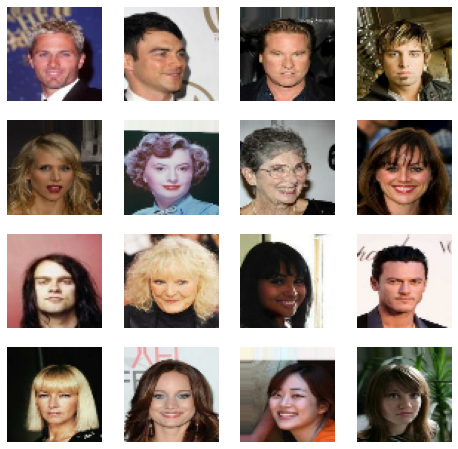

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from data_utils import load_faces_dataset, denormalize_from_tanh_range


data_dir = "/home/ecbm4040/img_align_celeba"

# Load dataset
dataset = load_faces_dataset(data_dir=data_dir)

print(dataset)

# Visualize the first batch
for batch in dataset.take(1):
    images = batch
    break

# Reverse normalization
imgs = denormalize_from_tanh_range(images)

# Plot
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i])
    plt.axis("off")
plt.show()



## 2. Training DCGAN model  
<span style="font-size: 1.2em;">We use the same hyperparameter values as the setting in original paper. Due to the limited computational resources, we trained the model only for 12 epochs, which may influence the performance of the model.</span>

In [ ]:
from model import Generator, Discriminator
import train_dcgan  
from train_dcgan import train, generate_and_save_images
# Set hyperparameters:
# We use the same hyperparameter values as the original paper
batchz_size = 128
dim = 100
lr = 0.0002
beta = 0.5
epochs = 12       # Due to limited computational resources compared to the original paper, 
                  # We only trained the model for 12 epochs to avoid kernel crashes, which may result in underfitting.

# Initialize models
generator = Generator(z_dim=dim)   # Generator of dcgan
discriminator = Discriminator()    # Discriminator of dcgan 

# Optimizers
g_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta)   # Use the same optimizer for both generator and discriminator as original paper
d_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta)

## Load CelebA data for training
dataset = load_faces_dataset(
    data_dir = data_dir,
    batch_size = 128,
    target_size = (64, 64),
    shuffle = True
)

# Plug the models, optimizers and hyperparameters initialized above in the train_dcgan module as its global variables
train_dcgan.generator = generator
train_dcgan.discriminator = discriminator
train_dcgan.g_optimizer = g_optimizer
train_dcgan.d_optimizer = d_optimizer
train_dcgan.batchz_size = batchz_size
train_dcgan.dim = dim

_ = train_dcgan.generator(tf.random.uniform([1, dim]))
_ = train_dcgan.discriminator(tf.random.uniform([1, 64, 64, 3]))

train(dataset, epochs)   # Train the dcgan model on celebA dataset
generate_and_save_images(generator, epochs)     # Generate 16 face images using the trained generator


Epoch 1/12
  d_loss: 1.1115, g_loss: 2.0115
Epoch 2/12
  d_loss: 0.9230, g_loss: 1.5962
Epoch 3/12
  d_loss: 0.9577, g_loss: 1.5124
Epoch 4/12
  d_loss: 0.9965, g_loss: 1.4093
Epoch 5/12
  d_loss: 1.0053, g_loss: 1.3772
Epoch 6/12
  d_loss: 0.9901, g_loss: 1.3834
Epoch 7/12
  d_loss: 0.9588, g_loss: 1.4312
Epoch 8/12
  d_loss: 0.9173, g_loss: 1.5110
Epoch 9/12
  d_loss: 0.8694, g_loss: 1.6067
Epoch 10/12
  d_loss: 0.8151, g_loss: 1.7369
Epoch 11/12
  d_loss: 0.7618, g_loss: 1.8442
Epoch 12/12
  d_loss: 0.7260, g_loss: 1.9715


<span style="font-size: 1.2em;">Using the trained generator and random noise vector, we generate new 16 face images to measure generation quality.</span>

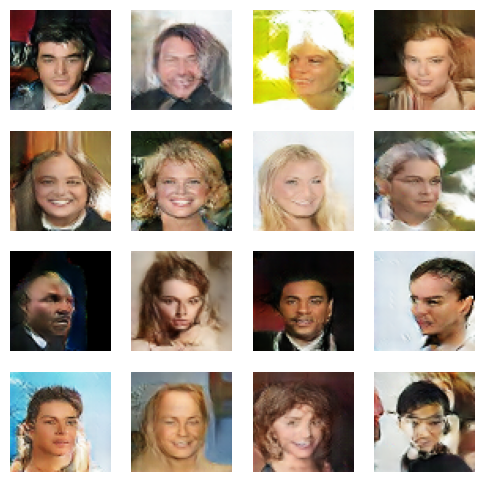

In [10]:
import sys
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))
from model import Generator


# Initialize generator
z_dim = 100
generator = Generator(z_dim=z_dim)

# Build network
z = tf.random.uniform([1, z_dim], minval=-1., maxval=1.)
_ = generator(z, training=False)

# Load generator trained on celebA
weight_path = r"C:\Users\Frankie\Desktop\NEURAL NETWRKS & DEEP LEARNING\project\e4040-fall2025-project-TEAM-bl3147-zz3459-dn2659\task2\saved_models\generator_celebA.h5"
generator.load_weights(weight_path)

# Generate 16 face images
z = tf.random.uniform([16, z_dim], minval=-1., maxval=1.)
fake_images = generator(z, training=False)

# denormalize to show the image data
fake_images = ((fake_images + 1) * 127.5).numpy().astype("uint8")

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_images[i])
    plt.axis("off")
plt.show()

# save image
save_dir = "generated_samples_from_trained_model"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "generated_faces.png")

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_images[i])
    plt.axis("off")

plt.savefig(save_path)
plt.close()




<span style="font-size: 1.2em;">  In general, our model already learned the overall geometric structure of the face, generated faces with a reasonable gender ratio and variations in skin color, hairstyle, and face shape, showing good diversity.  
The original DCGAN model produces much sharper and more realistic faces with clearer facial details, while our results are still slightly blurry and contain visible artifacts, which is consistent with the fact that our model is trained for only 12 epochs under limited computational resources.</span>

## 3. Save model

<span style="font-size: 1.2em;">Save the generator and discriminator of dcgan model trained on celebA dataset. We will use the generator in the "VECTOR ARITHMETIC" experiment.</span>

In [ ]:
# Create folder
save_dir = "/home/ecbm4040/e4040-fall12025-project-TEAM-bl3147-zz3459-dn2659/task2/saved_models"
os.makedirs(save_dir, exist_ok=True)

gen_path = os.path.join(save_dir, "celeba_gen")
disc_path = os.path.join(save_dir, "celeba_dis")

# Save full models (architecture + weights)
generator.save(gen_path)
discriminator.save(disc_path)

INFO:tensorflow:Assets written to: /home/ecbm4040/e4040-fall12025-project-TEAM-bl3147-zz3459-dn2659/task2/saved_models/celeba_gen/assets
INFO:tensorflow:Assets written to: /home/ecbm4040/e4040-fall12025-project-TEAM-bl3147-zz3459-dn2659/task2/saved_models/celeba_dis/assets


## 4. Vector Arithmetic on face sample

### 4.1  Generate 500 new face images
<span style="font-size: 1.2em;">First, we used the generator to create 500 new face images, and through our own manual screening, we selected images that fit the categories of smiling woman, neutral woman, neutral man, man with glasses, man without glasses, and woman without glasses.</span>

In [19]:
# For reproducibility: set seed
np.random.seed(123)       # NumPy seed
tf.random.set_seed(123)   # TensorFlow seed

num_samples = 500
z_dim = 100
z = tf.random.uniform([num_samples, z_dim], minval=-1., maxval=1.)

images = generator(z)
images = ((images + 1) * 127.5).numpy().astype("uint8")

# Make a folder
os.makedirs("generated_faces_VA", exist_ok=True)

# Save images in the folder
for i in range(num_samples):
    save_path = f"generated_faces_VA/face_{i:04d}.png"
    plt.imsave(save_path, images[i])



<span style="font-size: 1.2em;"> After observing the generated images in folder "generated_faces_VA", we selected the ones that met the criteria, three photos for each category.</span>

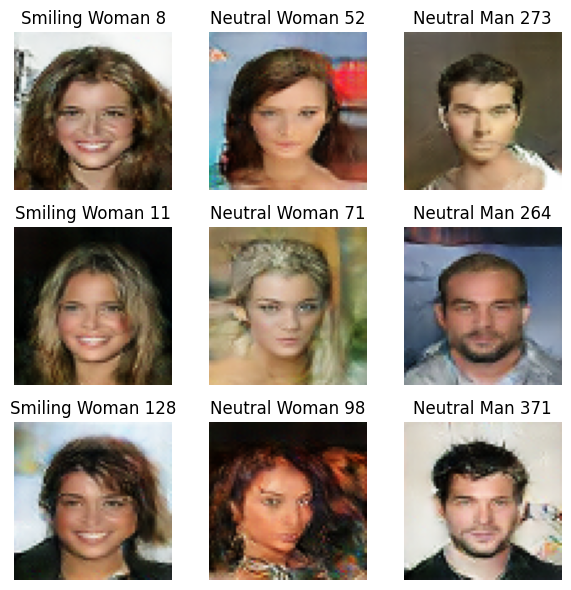

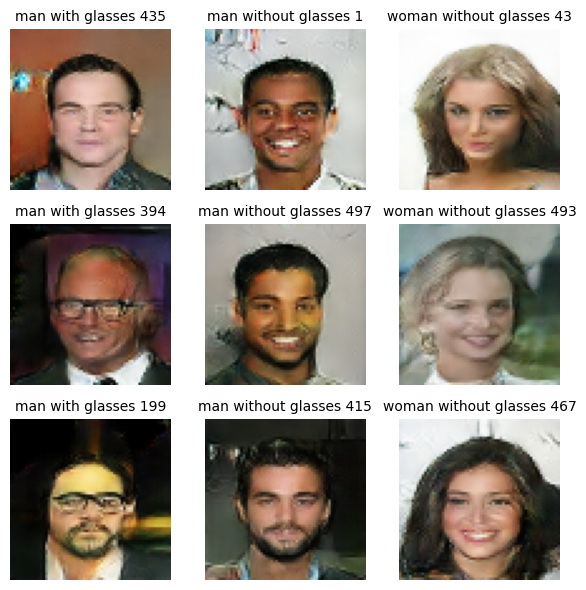

In [82]:
### Vector arithmetic on "smiling"
index_sw = [8, 11, 128]    # index of smiling woman
index_nw = [52, 71, 98]    # index of netural woman
index_nm = [273, 264, 371]    # index of netural man

plt.figure(figsize=(6, 6)) 
# put three images with the same features in the same column
for row in range(3):
    
    # smiling women
    plt.subplot(3, 3, row * 3 + 1)           
    plt.imshow(images[index_sw[row]])
    plt.title(f"Smiling Woman {index_sw[row]}")
    plt.axis("off")

    # neutral women
    plt.subplot(3, 3, row * 3 + 2)
    plt.imshow(images[index_nw[row]])
    plt.title(f"Neutral Woman {index_nw[row]}")
    plt.axis("off")

    # neutral men
    plt.subplot(3, 3, row * 3 + 3)
    plt.imshow(images[index_nm[row]])
    plt.title(f"Neutral Man {index_nm[row]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Vector arithmetic on "glass"
index_glass_m = [435, 394, 199]    # man with glasses
index_no_glass_m = [1, 497, 415]   # man without glasses
index_no_glass_w = [43, 493, 467]   # woman without glasses

plt.figure(figsize=(6, 6)) 
for row in range(3):
    
    # man with glasses
    plt.subplot(3, 3, row * 3 + 1)           
    plt.imshow(images[index_glass_m[row]])
    plt.title(f"man with glasses {index_glass_m[row]}", fontsize=10)
    plt.axis("off")

    # man without glasses
    plt.subplot(3, 3, row * 3 + 2)
    plt.imshow(images[index_no_glass_m[row]])
    plt.title(f"man without glasses {index_no_glass_m[row]}", fontsize=10)
    plt.axis("off")

    # woman without glasses
    plt.subplot(3, 3, row * 3 + 3)
    plt.imshow(images[index_no_glass_w[row]])
    plt.title(f"woman without glasses {index_no_glass_w[row]}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


## 4.2 Vector Arithmetic  
<span style="font-size: 1.2em;"> We perform vector arithmetic in the latent space to analyze whether "simple arithmetic operations revealed linear structure" in this example. By averaging latent vectors, we obtain representative vectors for each group. Then we use the (smiling woman vector - neutral woman vector + neutral man vector) to compute representative vector of smiling man(result).</span>  
$$
z_{sw} = \frac{1}{3} \left( z_{8} + z_{11} + z_{128} \right),   z_{nw} = \frac{1}{3} \left( z_{52} + z_{71} + z_{98} \right),  z_{nm} = \frac{1}{3} \left( z_{273} + z_{264} + z_{371} \right)
$$

$$
z_{sm} = z_{sw} - z_{nw} + z_{nm}
$$


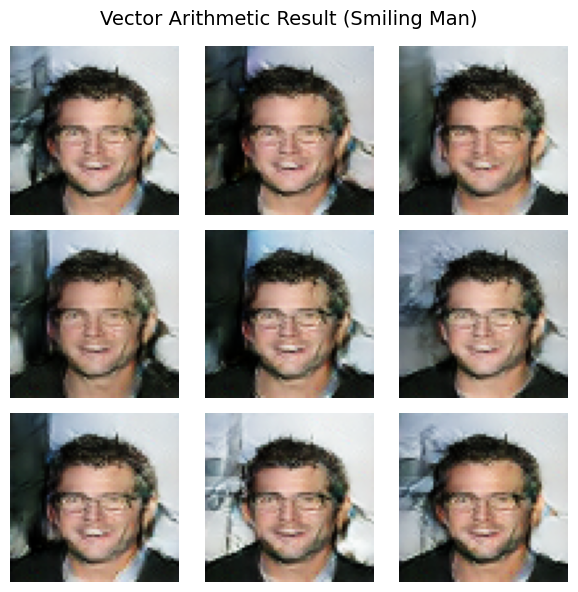

In [83]:
# Convert tensorflow tensor to numpy vector
z_np = z.numpy() 

z_sw = np.mean(z_np[index_sw], axis=0) # Compute the mean of three vectors corresponding to smiling women
z_nw = np.mean(z_np[index_nw], axis=0) # Neutral women
z_nm = np.mean(z_np[index_nm], axis=0) # Neutral men

# Vector Arithmetic
z_va_smile = z_sw - z_nw + z_nm

# Change shape from (100,) to (1, 100)
z_va_smile = np.expand_dims(z_va_smile, axis=0) 

# Generate new image
image_va_smile = generator(z_va_smile, training=False)
image_va_smile = ((image_va_smile + 1) * 127.5).numpy().astype("uint8")   # denormalization

noise = np.random.uniform(low=-0.25, high=0.25, size=(8, z_dim))
z_va_smile_noise = z_va_smile + noise
image_va_smile_noise = generator(z_va_smile_noise, training=False)
image_va_smile_noise = ((image_va_smile_noise + 1) * 127.5).numpy().astype("uint8")
all_images_smile = np.concatenate([image_va_smile, image_va_smile_noise], axis=0)

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images_smile[i])
    plt.axis("off")

plt.suptitle("Vector Arithmetic Result (Smiling Man)", fontsize=14)
plt.tight_layout()
plt.show()




<span style="font-size: 1.2em;"> Same as "smiling experiment" above, we use the (man with glasses vector - man without glasses vector + woman without glasses vector) to try to compute representative vector of woman with glasses.</span>  
$$
z_{\text{man with glasses}} = \frac{1}{3} \left( z_{435} + z_{394} + z_{199} \right),   z_{\text{man without glasses}} = \frac{1}{3} \left( z_{1} + z_{497} + z_{415} \right),  z_{\text{woman without glasses}} = \frac{1}{3} \left( z_{43} + z_{493} + z_{467} \right)
$$

$$
z_{\text{woman with glasses}} = z_{\text{man with glasses}} - z_{\text{man without glasses}} + z_{\text{woman without glasses}}
$$

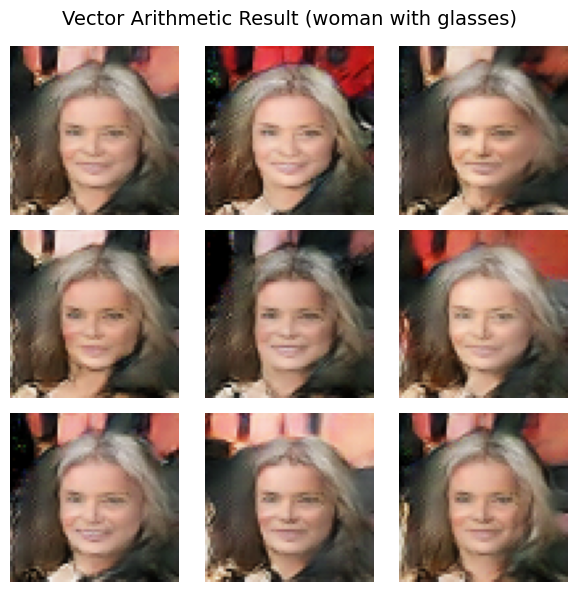

In [84]:
z_glass_m = np.mean(z_np[index_glass_m], axis=0)   # Compute the mean of three vectors corresponding to man with glasses
z_no_glass_m = np.mean(z_np[index_no_glass_m], axis=0)   # man without glasses
z_no_glass_w = np.mean(z_np[index_no_glass_w], axis=0)   # woman without glasses

# Vector Arithmetic
z_va_glass = z_glass_m - z_no_glass_m + z_no_glass_w

# Change shape from (100,) to (1, 100)
z_va_glass = np.expand_dims(z_va_glass, axis=0) 

# Generate new image
image_va_glass = generator(z_va_glass, training=False)
image_va_glass = ((image_va_glass + 1) * 127.5).numpy().astype("uint8")   # denormalization

z_va_glass_noise = z_va_glass + noise
image_va_glass_noise = generator(z_va_glass_noise, training=False)
image_va_glass_noise = ((image_va_glass_noise + 1) * 127.5).numpy().astype("uint8")
all_images_glass = np.concatenate([image_va_glass, image_va_glass_noise], axis=0)

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images_glass[i])
    plt.axis("off")

plt.suptitle("Vector Arithmetic Result (woman with glasses)", fontsize=14)
plt.tight_layout()
plt.show()

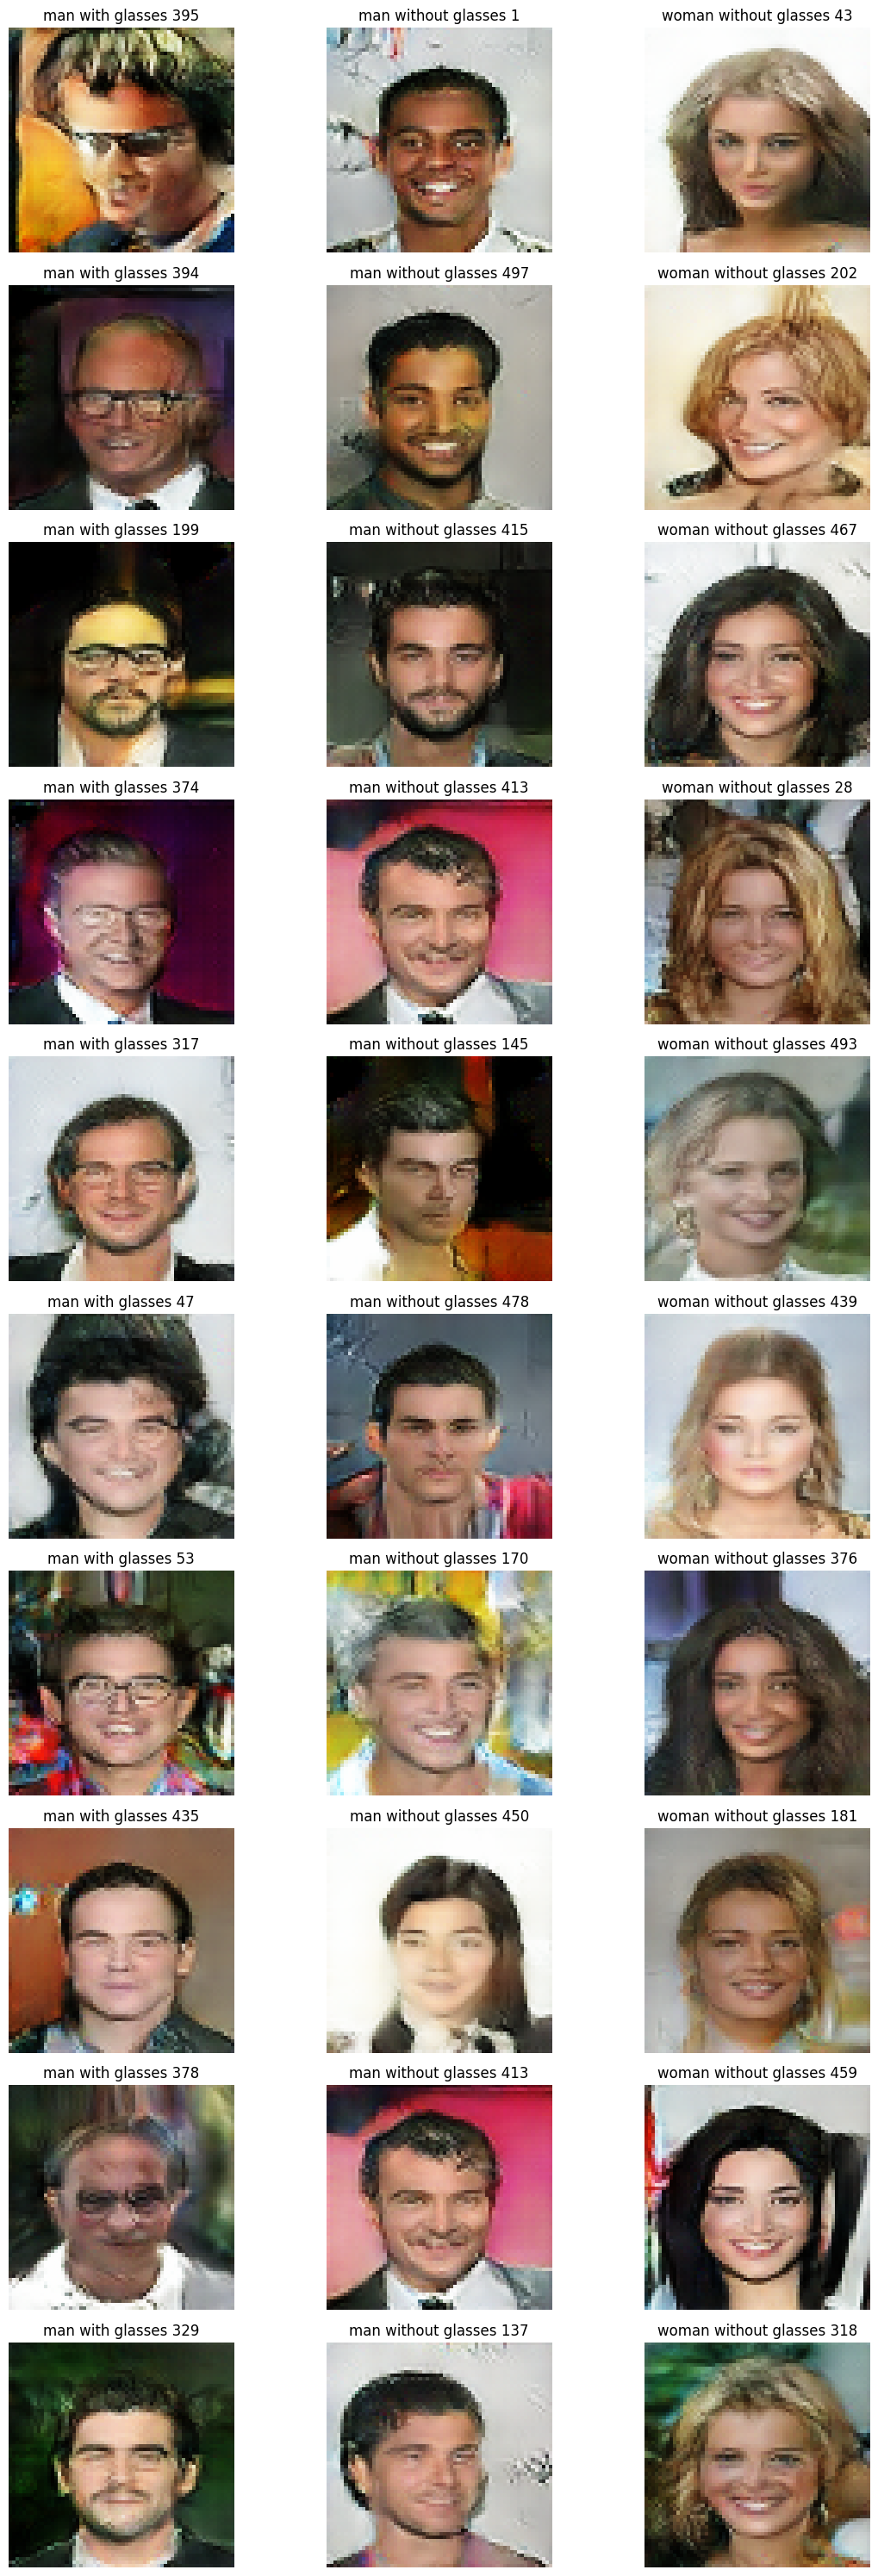

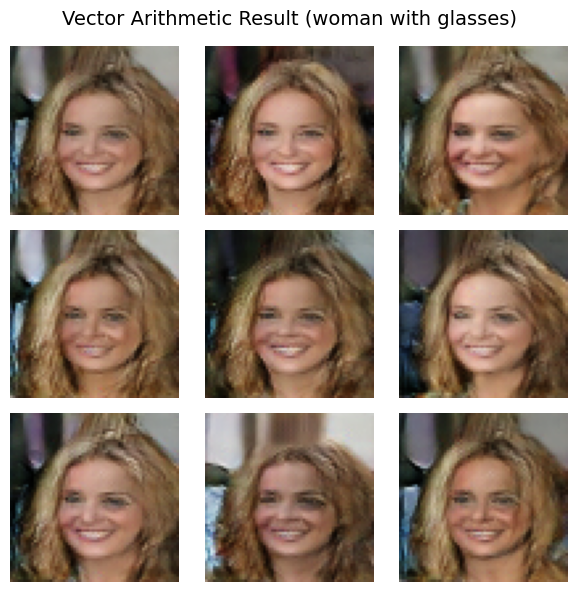

In [86]:
index_glass_m = [395, 394, 199, 374, 317, 47, 53, 435, 378, 329]    # man with glasses
index_no_glass_m = [1, 497, 415, 413, 145, 478, 170, 450, 413, 137]   # man without glasses
index_no_glass_w = [43, 202, 467, 28, 493, 439, 376, 181, 459, 318]   # woman without glasses


plt.figure(figsize=(12, 30)) 
for row in range(10):
    
    # man with glasses
    plt.subplot(10, 3, row * 3 + 1)           
    plt.imshow(images[index_glass_m[row]])
    plt.title(f"man with glasses {index_glass_m[row]}")
    plt.axis("off")

    # man without glasses
    plt.subplot(10, 3, row * 3 + 2)
    plt.imshow(images[index_no_glass_m[row]])
    plt.title(f"man without glasses {index_no_glass_m[row]}")
    plt.axis("off")

    # woman without glasses
    plt.subplot(10, 3, row * 3 + 3)
    plt.imshow(images[index_no_glass_w[row]])
    plt.title(f"woman without glasses {index_no_glass_w[row]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


z_glass_m = np.mean(z_np[index_glass_m], axis=0)   # Compute the mean of three vectors corresponding to man with glasses
z_no_glass_m = np.mean(z_np[index_no_glass_m], axis=0)   # man without glasses
z_no_glass_w = np.mean(z_np[index_no_glass_w], axis=0)   # woman without glasses

# Vector Arithmetic
z_va_glass = z_glass_m - z_no_glass_m + z_no_glass_w

# Change shape from (100,) to (1, 100)
z_va_glass = np.expand_dims(z_va_glass, axis=0) 

# Generate new image
image_va_glass = generator(z_va_glass, training=False)
image_va_glass = ((image_va_glass + 1) * 127.5).numpy().astype("uint8")   # denormalization

z_va_glass_noise = z_va_glass + noise
image_va_glass_noise = generator(z_va_glass_noise, training=False)
image_va_glass_noise = ((image_va_glass_noise + 1) * 127.5).numpy().astype("uint8")
all_images_glass = np.concatenate([image_va_glass, image_va_glass_noise], axis=0)

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images_glass[i])
    plt.axis("off")

plt.suptitle("Vector Arithmetic Result (woman with glasses)", fontsize=14)
plt.tight_layout()
plt.show()

